In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import os


file_path = "C:/Users/Shirik/Dropbox (Weizmann Institute)/Shiri/Courses/AMLLS/Project/Dataset/diabetes+130-us+hospitals+for+years+1999-2008/"
os.chdir(file_path)
os.getcwd()

full_data_file_name = "diabetic_data.csv"
training_file_name = "train_cohort.csv"
training_df = pd.read_csv(file_path+training_file_name)
print(training_df.info())

# Check the data types of the DataFrame after conversion
print(training_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30420 entries, 0 to 30419
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                30420 non-null  int64 
 1   encounter_id              30420 non-null  int64 
 2   patient_nbr               30420 non-null  int64 
 3   race                      30420 non-null  object
 4   gender                    30420 non-null  object
 5   age                       30420 non-null  object
 6   weight                    30420 non-null  object
 7   admission_type_id         30420 non-null  int64 
 8   discharge_disposition_id  30420 non-null  int64 
 9   admission_source_id       30420 non-null  int64 
 10  time_in_hospital          30420 non-null  int64 
 11  payer_code                30420 non-null  object
 12  medical_specialty         30420 non-null  object
 13  num_lab_procedures        30420 non-null  int64 
 14  num_procedures        

In [2]:
### There are 3 readmission categorical features that contain digits which is not informative and problematic for EDA purposes

#Make sure the mapping file is in the current dir
#print(os.listdir())

#Read readmission mapping file
mapping_df = pd.read_csv("IDS_mapping.csv",header=None)
#print(mapping_df.head())
original_shape_num_rows = mapping_df.shape[0]

#Remove empty rows
mapping_df = mapping_df.dropna(how='all', inplace=False) #removes 2 gap rows

#Fill empty desctioption cells with NaNs they were previously NULL
mapping_df = mapping_df.fillna(value='NaN', inplace=False)
print("Does the new mapping_df has less rows than the original? ",mapping_df.shape[0]< original_shape_num_rows) #QC

#Reset indices
mapping_df = mapping_df.reset_index(drop=True)


Does the new mapping_df has less rows than the original?  True


In [3]:
### Rearrange IDS_mapping table by storing each categorical column with its description in a df inside a dictionary
#Find rows containing the string "id" in any column
id_rows = mapping_df[mapping_df.apply(lambda row: row.astype(str).str.contains('_id', case=False)).any(axis=1)]
#print(id_rows)
id_names = list(id_rows[0])
#print(mapping_df.iloc[9])

# Extract the index of the id rows
id_rows_indices = list(id_rows.index)

#print(id_rows_indices)

# Create a dictionary with the 3 mapping dataframes
mapping_dictionary = {}

#Iterate over id_names to create subsets of mapping_df
for id_i in range(0,len(id_rows_indices)-1):
    start_index = id_rows_indices[id_i]
    end_index = id_rows_indices[id_i+1]
    #print(start_index,end_index)
    
    # Extract the subset DataFrame
    current_id_df = mapping_df.iloc[start_index:end_index]  #+1 Include end_index
    #print(current_id_df)
                 
    #Assign the values of the first row as column names
    current_id_df.columns = current_id_df.iloc[0]
    #print(current_id_df.columns)

    # Drop the first row after using it as column names
    current_id_df = current_id_df[1:].reset_index(drop=True)

    # Assign the subset DataFrame to the corresponding key in the dictionary
    mapping_dictionary[id_names[id_i]] = current_id_df
    
# Add the last subset DataFrame explicitly
last_start_index = id_rows_indices[-1]
last_id_df = mapping_df.iloc[last_start_index:]
last_id_df.columns = last_id_df.iloc[0]
last_id_df = last_id_df[1:].reset_index(drop=True)
mapping_dictionary[id_names[-1]] = last_id_df

print("The dictionary contains",len(mapping_dictionary.items()), "items")

#View dictionary dfs
for key, df in mapping_dictionary.items():
    print(f"Head of DataFrame {key}:")
    print(df.head())
    print()


The dictionary contains 3 items
Head of DataFrame admission_type_id:
0 admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available

Head of DataFrame discharge_disposition_id:
9 discharge_disposition_id                                        description
0                        1                                 Discharged to home
1                        2  Discharged/transferred to another short term h...
2                        3                      Discharged/transferred to SNF
3                        4                      Discharged/transferred to ICF
4                        5  Discharged/transferred to another type of inpa...

Head of DataFrame admission_source_id:
40 admission_source_id                                      description
0                    1                               Physician Referral
1                    2  

In [4]:
### Replace the values in the training df with the values in the dictionary
#Avoid overight of the trining df (optional)
training_df_new = training_df.copy()
#print(training_df_new.head())
training_df_new[id_names] = training_df_new[id_names].astype('str')

# Check that the columns in the DataFrame appear in the list
matching_columns = [col for col in training_df_new.columns if col in id_names]
matching_columns == id_names #QC

#Define these columns as str
training_df_new[training_df_new.columns]

# Iterate over rows in training_df_new
for id_i in id_names:
#Extract the df in mapping_dictionary for the the id_column in training_df_new
    current_dict_df = mapping_dictionary[id_i]
    #Merge the discionary columns with the training_df_new
    training_df_new = training_df_new.merge(current_dict_df,on = id_i, how ='left',suffixes=['_left','_right'])

#Rename the new columns - last 3 columns in the df
new_column_names = [element[:-3] + "_descriptor" if element.endswith("_id") else element for element in id_names]

# Create a mapping dictionary for renaming
rename_dict = dict(zip(training_df_new.columns[-3:], new_column_names))
training_df_new = training_df_new.rename(columns=rename_dict)
print(training_df_new.iloc[:,-3:])


      admission_type_descriptor  \
0                           NaN   
1                     Emergency   
2                     Emergency   
3                     Emergency   
4                     Emergency   
...                         ...   
30415                 Emergency   
30416                  Elective   
30417                  Elective   
30418                 Emergency   
30419                 Emergency   

                        discharge_disposition_descriptor  \
0                                             Not Mapped   
1                                     Discharged to home   
2                                     Discharged to home   
3                                     Discharged to home   
4                                     Discharged to home   
...                                                  ...   
30415                      Discharged/transferred to ICF   
30416  Discharged/transferred to home with home healt...   
30417                                 D

In [29]:
#Change '?' to NaNa in the medical_specialty feature
columns_to_clean = ['race','medical_specialty']  # Specify the column to clean
training_df_new[columns_to_clean] = training_df_new[columns_to_clean].replace('?', np.NaN)

# EDA
## Categorical features

In [22]:
# #Filter the training set to diabetes patients only - SKIP, Yael incorporated this already 
# diagnosis_cols_list = ['diag_' + str(num) for num in [1,2,3]]

# # Regex pattern to locate diabeteic pateints 
# pattern = r'250(\.\d{2})?'

# # count diabetes diagnosis appearance  in all 3 daignosis columns 
# diag_count = training_df_new[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)

# diabetic_only_df = training_df_new[diag_count > 0]

# print("The number of rowd left:",diabetic_only_df.shape[0])

The number of rowd left: 38024


C:\Users\Shirik\AppData\Local\Temp/ipykernel_36340/2851440478.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  diag_count = training_df_new[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)


In [39]:
#Focus on the categorical features only
#print(training_df_new.info())

all_columns = training_df_new.columns

#Subset all categorical
categorical = ['race', 'gender', 'age','medical_specialty','max_glu_serum', \
'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride', \
'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose', \
'miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin',\
'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change','diabetesMed',\
'admission_type_descriptor', 'discharge_disposition_descriptor','admission_source_descriptor']

#Subset depografics
demographics = ['race', 'gender', 'age']

#Subset medications
medications = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride', \
'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose', \
'miglitol','troglitazone','tolazamide','examide','citoglipton','glyburide-metformin',\
'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

print(len(medications))

training_df_new_categorical = training_df_new[categorical].astype('category')
print(training_df_new_categorical.shape)

22
(30420, 34)


Female    16414
Male      14006
Name: gender, dtype: int64
53.95792241946088
46.04207758053912
Caucasian          21401
AfricanAmerican     6819
Hispanic             761
Other                521
Asian                197
Name: race, dtype: int64


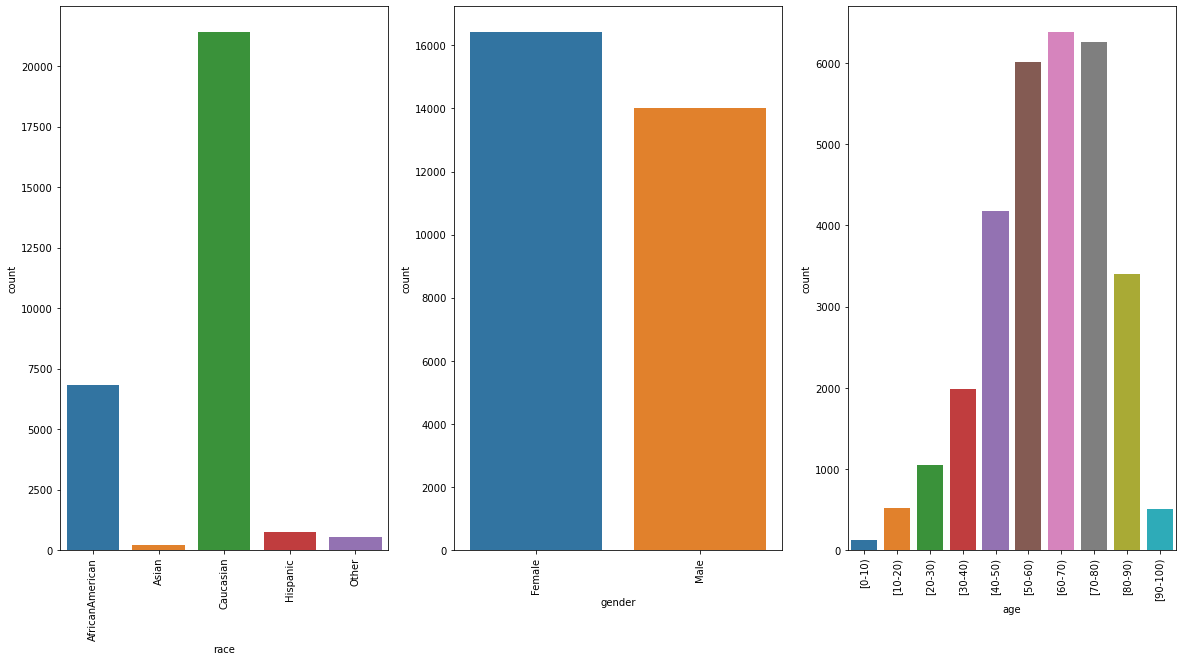

In [89]:
#Demographics: Race, gender and age
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for variable, subplot in zip(demographics, ax.flatten()):
    sns.countplot(data = training_df_new_categorical,x = variable, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
#Extracrt specific count values
#Gender
gender_counts = training_df_new_categorical['gender'].value_counts()
print(gender_counts)
female_percent = 100*gender_counts[0]/len(training_df_new)
print(female_percent)
male_percent = 100*gender_counts[1]/len(training_df_new)
print(male_percent)
female_percent + male_percent < 100 #QC

#Race
race_counts = training_df_new_categorical['race'].value_counts()
print(race_counts)

#Insights:
1. The most abundunt race is Caucasian followed by AfricanAmerican
2. There are 

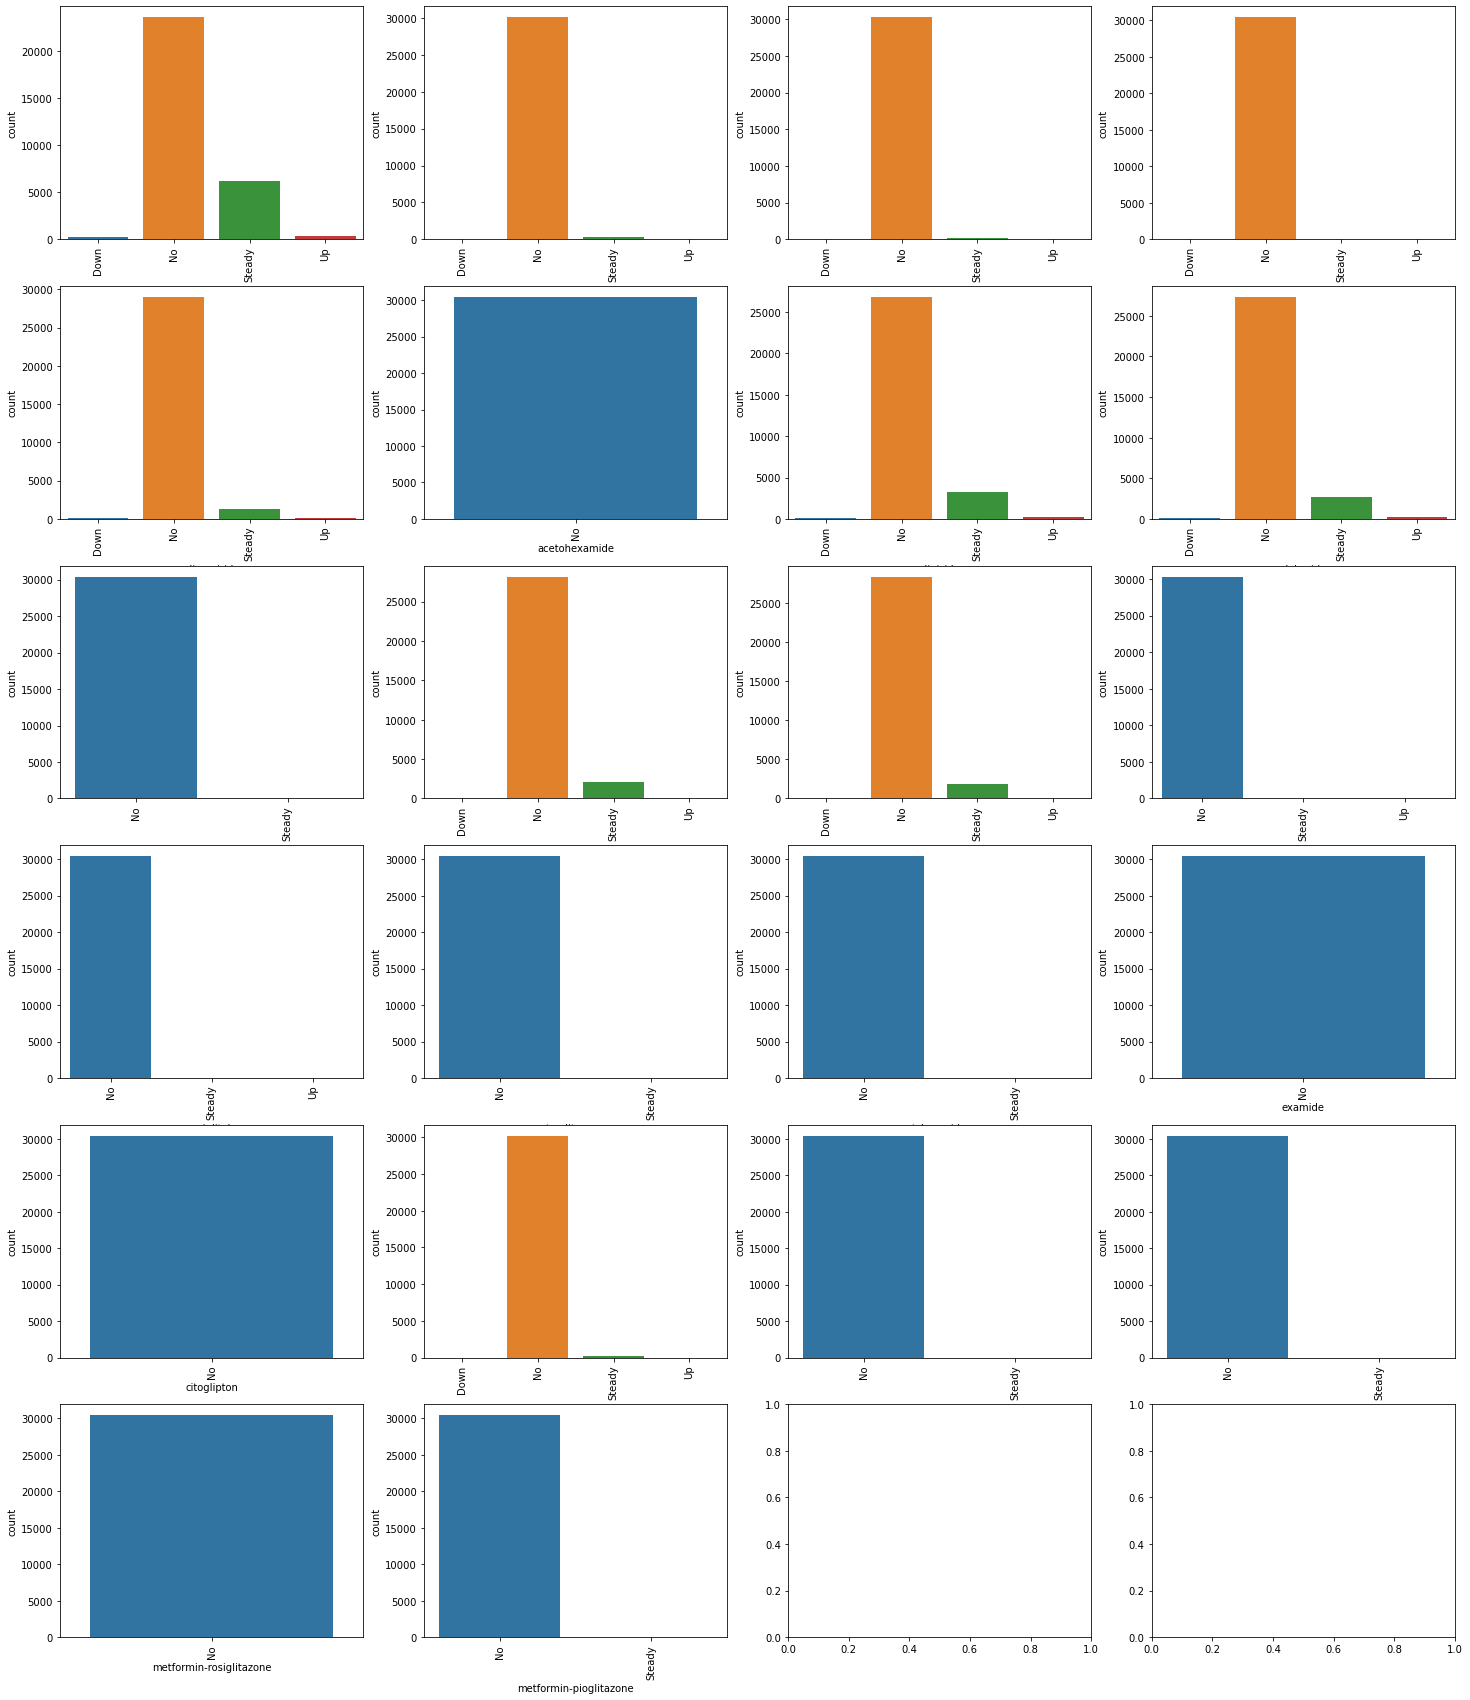

In [65]:
#Medications
fig, ax = plt.subplots(6, 4, figsize=(25, 30))
for variable, subplot in zip(medications, ax.flatten()):
    sns.countplot(data = training_df_new_categorical,x = variable, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)